In [12]:
import talib as ta
from datetime import datetime
from datetime import timedelta
from bigtrader.constant import Direction, OrderType

STRATEGY_NAME = "STRATEGY_1m"
        
def initialize(context):
    """初始化"""
    print("initialize")  
    context.symbol = instruments
#     context.count = 0
    context.my_instruments = context.get_conf_param("instruments")#从传入参数中获取需要交易的合约
    context.closetime_day = context.get_conf_param("closetime_day")#日内策略白盘平仓时间，一般14:58
    context.closetime_night = context.get_conf_param("closetime_night")#日内策略夜盘平仓时间，一般22:58，注意有些商品夜盘收盘时间不一样
    context.order_num = context.get_conf_param("order_num")#下单手数
    context.set_universe(context.my_instruments)#设置需要处理的合约
    context.stopLossPrice = 50    # 设置止损点数
    context.max_high = 0
    context.max_low = 0
#     # 如果是非交易时间段，等到上午9点或晚上21点再执行algo()
#     schedule(schedule_func = algo, date_rule = '1d', time_rule = '09:00:00')
#     schedule(schedule_func = algo, date_rule = '1d', time_rule = '21:00:00')
def before_trading(context, data):
    """盘前处理"""
    #print("before_trading")
    context.subscribe(context.my_instruments) #注册合约
    context.index = 0
    context.current_instruments = []
#     for instr in context.my_instruments:
#         index = instr.find('.')
#         #获取当前主力合约，如果含有.即指定某个具体合约，否则认为是需要处理主连合约
#         if index<=0:
#             context.current_instruments.append(data.current_dominant(instr))
#         else:#使用指定合约
#             context.current_instruments.append(instr)                                   
#     print("当前主力合约", context.current_instruments)
    context.max_high = 0
    context.max_low = 0
    history_data_for_breaker = data.history(context.my_instruments, ["high","low","open","close"], 1, "1d")
    # 开盘价直接在data最后一个数据里取到,前一交易日的最高和最低价为history_data里面的倒数第二条中取到
    high = history_data_for_breaker['high'].iloc[0]  # 前一日的最高价
    low = history_data_for_breaker['low'].iloc[0]  # 前一日的最低价
    close = history_data_for_breaker['close'].iloc[0]  # 前一日的收盘价
    pivot = (high + low + close) / 3  # 枢轴点
    context.bBreak = high + 2 * (pivot - low)  # 突破买入价 
    context.sSetup = pivot + (high - low)  # 观察卖出价
    context.sEnter = 2 * pivot - low  # 反转卖出价
    context.bEnter = 2 * pivot - high  # 反转买入价
    context.bSetup = pivot - (high - low)  # 观察买入价
    context.sBreak = low - 2 * (high - pivot)  # 突破卖出价

    
def handle_data(context, data):
    """Bar行情推送"""
    cur_date =  data.current_dt
    cur_hm = cur_date.strftime('%H:%M') #time
    today_high = data.current(context.my_instruments,'high')
    today_low = data.current(context.my_instruments,'low')
    context.max_high = max(context.max_high,today_high)
    context.max_low = max(context.max_high,today_low) 
    # 获取止损价
    STOP_LOSS_PRICE = context.stopLossPrice
    # 分别获取多头持仓，和空头持仓
    position_long = context.get_position(context.my_instruments, Direction.LONG)
    position_short = context.get_position(context.my_instruments, Direction.SHORT)
    # 获取当前价格
    price = data.current(context.my_instruments, "close")
    #部分品种夜盘收盘时间不一样，此时间表示指定的尾盘平仓时间往后偏移30分钟，这段时间内不能开新仓，只能平仓。给30分钟是为了足够的冗余
    closetime_nightshift = (datetime.strptime(context.closetime_night,'%H:%M') + timedelta(minutes = 30)).strftime('%H:%M')
    #尾盘平仓
    if((cur_hm>=context.closetime_day and cur_hm<="15:00") or (cur_hm>=context.closetime_night and cur_hm<=closetime_nightshift)):
        if(position_long.current_qty != 0):
            rv = context.sell_close(context.my_instruments, position_long.avail_qty, price, order_type=OrderType.MARKET)
            msg = str(data.current_dt) +  " 尾盘平多 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
            context.write_log(msg, stdout=1) #输出关键日志
        if(position_short.current_qty != 0):
            rv = context.buy_close(context.my_instruments, position_short.avail_qty, price, order_type=OrderType.MARKET)
            msg = str(data.current_dt) +  " 尾盘平空 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
            context.write_log(msg, stdout=1) #输出关键日志
        #尾盘不开新仓，直接返回
        return
    # 突破策略:position_short
    if position_long.current_qty == 0 and position_short.current_qty == 0:  # 空仓条件下
        if price > context.bBreak:
            # 在空仓的情况下，如果盘中价格超过突破买入价，则采取趋势策略，即在该点位开仓做多
            rv = context.buy_open(context.my_instruments, context.order_num, price, order_type=OrderType.MARKET)
            msg = str(data.current_dt) +  " 开多 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
            context.write_log(msg, stdout=1) #输出关键日志
            context.open_position_price = price
        elif price < context.sBreak:
            # 在空仓的情况下，如果盘中价格跌破突破卖出价，则采取趋势策略，即在该点位开仓做空
            rv = context.sell_open(context.my_instruments, context.order_num, price, order_type=OrderType.MARKET)
            msg = str(data.current_dt) +  " 开空 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
            context.write_log(msg, stdout=1) #输出关键日志
            context.open_position_price = price
    # 设置止损条件
    else:  # 有持仓时
        # 开仓价与当前行情价之差大于止损点则止损
        if (position_long.current_qty != 0 and context.open_position_price - price >= STOP_LOSS_PRICE) or \
                (position_short.current_qty != 0 and price - context.open_position_price >= STOP_LOSS_PRICE):
            print('达到止损点，全部平仓')
            if(position_long.current_qty != 0):
                rv = context.sell_close(context.my_instruments, position_long.avail_qty, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 止损平多 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志
            if(position_short.current_qty != 0):
                rv = context.buy_close(context.my_instruments, position_short.avail_qty, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 止损平空 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志
        # 反转策略:
        if position_long.current_qty != 0:  # 多仓条件下
            if context.max_high > context.sSetup and price < context.sEnter:
                # 多头持仓,当日内最高价超过观察卖出价后
                # 盘中价格出现回落，且进一步跌破反转卖出价构成的支撑线时
                # 采取反转策略，即在该点位反手做空
                rv = context.sell_close(context.my_instruments, position_long.avail_qty, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 平多 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志
                rv = context.sell_open(context.my_instruments, context.order_num, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 开空 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志  
                print("多头持仓,当日内最高价超过观察卖出价后跌破反转卖出价: 反手做空")
                context.open_position_price = price
        elif position_short.current_qty != 0:  # 空头持仓
            if context.max_low < context.bSetup and price > context.bEnter:
                # 空头持仓，当日内最低价低于观察买入价后，
                # 盘中价格出现反弹，且进一步超过反转买入价构成的阻力线时，
                # 采取反转策略，即在该点位反手做多
                rv = context.buy_close(context.my_instruments, position_short.avail_qty, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 平空 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志
                rv = context.buy_open(context.my_instruments, context.order_num, price, order_type=OrderType.MARKET)
                msg = str(data.current_dt) +  " 开多 for " + context.my_instruments + " 最新价=" + str(price) + " rv:" + str(rv)
                context.write_log(msg, stdout=1) #输出关键日志   
                print("空头持仓,当日最低价低于观察买入价后超过反转买入价: 反手做多")
                context.open_position_price = price
            
def handle_order(context, order):
    """委托回报推送"""
    msg = "handle_order:" + order.log_str()
    context.write_log(msg, stdout=1) 
         
def handle_trade(context, trade):
    """成交回报推送"""
    msg = "handle_trade:" + trade.log_str()
    context.write_log(msg, stdout=1) 
    # 分别获取多头持仓，和空头持仓
    position_long = context.get_position(trade.symbol, Direction.LONG)
    position_short = context.get_position(trade.symbol, Direction.SHORT)
    msg = "当前多头持仓:"+ str(position_long) + "当前空头持仓:"+ str(position_short)
    context.write_log(msg, stdout=1) 
    
instruments = "RB2005.SHF" #["RB2110.SHF"] #["RB2110.SHF"] [I2105.DCE"] ['RB']# RB2101.SHF 如果想用主连合约，可以出入合约简码，例如RB,I,CF

#需要交易者传入的参数
strategy_setting = [
    {
        "instruments": instruments,
        "order_num": 2,
        "closetime_day": "14:58",
        "closetime_night": "22:58"
    }    
    
]
start_date = "2020-01-21"
end_date = "2020-04-01"
md = M.hfbacktest.v1(start_date=start_date,
                     end_date=end_date,
                     instruments=[instruments], #只传入一个合约便于策略逻辑展示
                     capital_base=100000,
                     product_type=Product.FUTURE,
                     frequency=Frequency.MINUTE,
                     initialize=initialize,
                     before_trading_start=before_trading,
                     handle_data=handle_data,
                     handle_order=handle_order,
                     handle_trade=handle_trade,
                     plot_charts=True,
                     volume_limit=1.0,
                     disable_cache=0,
                     show_debug_info=1,
                     strategy_setting=strategy_setting,
                     slippage_type=SlippageType.FIXED,#滑点固定模式
                     slippage_value=1.0,#买卖双向各1个滑点
                     m_deps=np.random.rand())

[2021-05-21 15:04:03.921449] INFO: moduleinvoker: hfbacktest.v1 开始运行..

[2021-05-21 15:04:03.929157] INFO: hfbacktest: passed-in daily_data_ds:None

[2021-05-21 15:04:03.932601] INFO: hfbacktest: passed-in minute_data_ds:None

[2021-05-21 15:04:03.935011] INFO: hfbacktest: passed-in tick_data_ds:None

[2021-05-21 15:04:03.937527] INFO: hfbacktest: passed-in each_data_ds:None

[2021-05-21 15:04:03.939543] INFO: hfbacktest: passed-in dominant_data_ds:None

[2021-05-21 15:04:03.941277] INFO: hfbacktest: passed-in benchmark_data_ds:None

[2021-05-21 15:04:03.943454] INFO: hfbacktest: passed-in trading_calendar_ds:None

[2021-05-21 15:04:03.945013] INFO: hfbacktest: biglearning V1.2.0

[2021-05-21 15:04:03.946607] INFO: hfbacktest: bigtrader v1.7.6

[2021-05-21 15:04:03.965953] INFO: hfbacktest: strategy callbacks:{'on_init': <function initialize at 0x7f210ddbd0d0>, 'on_start': <function before_trading at 0x7f210e416550>, 'handle_data': <function handle_data at 0x7f210e4169d0>, 'handle_trade': <function handle_trade at 0x7f210e416b80>, 'handle_order': <function handle_order at 0x7f210e416a60>}

[2021-05-21 15:04:03.978750] INFO: hfbacktest: begin reading history data, 2020-01-21 00:00:00~2020-04-01, disable_cache:0

[2021-05-21 15:04:03.980652] INFO: hfbacktest: reading benchmark data 2020-01-01 00:00:00~2020-04-01...

[2021-05-21 15:04:04.024656] INFO: moduleinvoker: cached.v2 开始运行..

[2021-05-21 15:04:04.351281] INFO: moduleinvoker: cached.v2 运行完成[0.326616s].

[2021-05-21 15:04:04.393023] INFO: hfbacktest: reading daily data 2018-07-24 00:00:00~2020-04-01...

[2021-05-21 15:04:04.397942] INFO: moduleinvoker: cached.v2 开始运行..

[2021-05-21 15:04:04.759827] INFO: moduleinvoker: cached.v2 运行完成[0.361852s].

[2021-05-21 15:04:04.816049] INFO: hfbacktest: reading minute data 2019-12-09 00:00:00~2020-04-01...

[2021-05-21 15:04:04.821198] INFO: moduleinvoker: cached.v2 开始运行..

[2021-05-21 15:04:05.514001] INFO: moduleinvoker: cached.v2 运行完成[0.692787s].

[2021-05-21 15:04:05.570622] INFO: hfbacktest: reading dominant data 2020-01-10 00:00:00~2020-04-01...

[2021-05-21 15:04:05.576896] INFO: moduleinvoker: cached.v2 开始运行..

[2021-05-21 15:04:05.727919] INFO: moduleinvoker: cached.v2 运行完成[0.151022s].

[2021-05-21 15:04:05.770446] INFO: hfbacktest: cached_benchmark_ds:DataSource(19d4a3bd638a40409f34458e805dbf42T)

[2021-05-21 15:04:05.773102] INFO: hfbacktest: cached_daily_ds:DataSource(6e1cb259b60d49899f1e6938c8789010T)

[2021-05-21 15:04:05.776835] INFO: hfbacktest: cached_minute_ds:DataSource(41b74f5afe9f466caf37dd1794078db1T)

[2021-05-21 15:04:05.779889] INFO: hfbacktest: cached_tick_ds:None

[2021-05-21 15:04:05.781504] INFO: hfbacktest: cached_each_ds:None

[2021-05-21 15:04:05.782493] INFO: hfbacktest: dominant_data_ds:DataSource(bf850fb5dbce42cda1f62790fd9036acT)

[2021-05-21 15:04:05.783605] INFO: hfbacktest: read history data done, call run_backtest()

end_date= 2020-04-01
2021-05-21 15:04:05.803960 run trading v1.7.6 
2021-05-21 15:04:05.804090 init history datas... 
2021-05-21 15:04:05.823004 init trading env... 
2021-05-21 15:04:05.823494 run_backtest() capital:100000, frequency:1m, product_type:future, date:2020-01-21 00:00:00 ~ 2020-04-01 00:00:00 
2021-05-21 15:04:05.824038 create_app app_name:Strategy already created! 
2021-05-21 15:04:05.824402 run_backtest() running... 
initialize
2021-05-21 15:04:05.917398 backtest transforming 1m...


2021-05-21 15:04:06.097382 strategy_20210521(bkt999,): handle_order:[bkt999,1,RB2005.SHF,short,open,0,2,3559.0,pending,10:42:00,1] 
2021-05-21 15:04:06.097673 strategy_20210521(bkt999,): 2020-01-21 10:42:00 开空 for RB2005.SHF 最新价=3559.0 rv:0 
2021-05-21 15:04:06.100379 strategy_20210521(bkt999,): handle_order:[bkt999,1,RB2005.SHF,short,open,2,2,3559.0,filled,10:42:00,1] 
2021-05-21 15:04:06.100834 strategy_20210521(bkt999,): handle_trade:[bkt999,1,RB2005.SHF,short,open,2,3559.0,SHFE.1,10:43:00.000000] 
2021-05-21 15:04:06.100947 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3559.0,last_price:3559.0) 


2021-05-21 15:04:06.302691 strategy_20210521(bkt999,): handle_order:[bkt999,2,RB2005.SHF,long,close_today,0,2,3570.0,pending,14:58:00,2] 
2021-05-21 15:04:06.303495 strategy_20210521(bkt999,): 2020-01-21 14:58:00 尾盘平空 for RB2005.SHF 最新价=3570.0 rv:0 
2021-05-21 15:04:06.305595 strategy_20210521(bkt999,): handle_order:[bkt999,2,RB2005.SHF,long,close_today,2,2,3570.0,filled,14:58:00,2] 
2021-05-21 15:04:06.306150 strategy_20210521(bkt999,): handle_trade:[bkt999,2,RB2005.SHF,long,close_today,2,3571.0,SHFE.2,14:59:00.000000] 
2021-05-21 15:04:06.306265 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3559.0,last_price:3571.0) 


2021-05-21 15:04:07.582649 strategy_20210521(bkt999,): handle_order:[bkt999,3,RB2005.SHF,short,open,0,2,3233.0,pending,09:01:00,3] 
2021-05-21 15:04:07.582956 strategy_20210521(bkt999,): 2020-02-03 09:01:00 开空 for RB2005.SHF 最新价=3233.0 rv:0 
2021-05-21 15:04:07.585246 strategy_20210521(bkt999,): handle_order:[bkt999,3,RB2005.SHF,short,open,2,2,3233.0,filled,09:01:00,3] 
2021-05-21 15:04:07.586329 strategy_20210521(bkt999,): handle_trade:[bkt999,3,RB2005.SHF,short,open,2,3232.0,SHFE.3,09:02:00.000000] 
2021-05-21 15:04:07.586466 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3232.0,last_price:3232.0) 
达到止损点，全部平仓
2021-05-21 15:04:07.684168 strategy_20210521(bkt999,): handle_order:[bkt999,4,RB2005.SHF,long,close_today,0,2,3288.0,pending,09:59:00,4] 
2021-05-21 15:04:07.684455 strategy_20210521(bkt999,): 2020-02-03 09:59:00 止损平空 for RB2005

2021-05-21 15:04:07.992425 strategy_20210521(bkt999,): handle_order:[bkt999,6,RB2005.SHF,long,close_today,0,2,3233.0,pending,14:58:00,6] 
2021-05-21 15:04:07.992717 strategy_20210521(bkt999,): 2020-02-03 14:58:00 尾盘平空 for RB2005.SHF 最新价=3233.0 rv:0 
2021-05-21 15:04:07.994942 strategy_20210521(bkt999,): handle_order:[bkt999,6,RB2005.SHF,long,close_today,2,2,3233.0,filled,14:58:00,6] 
2021-05-21 15:04:07.995788 strategy_20210521(bkt999,): handle_trade:[bkt999,6,RB2005.SHF,long,close_today,2,3234.0,SHFE.6,14:59:00.000000] 
2021-05-21 15:04:07.996014 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3288.0,last_price:3234.0) 


2021-05-21 15:04:10.635686 strategy_20210521(bkt999,): handle_order:[bkt999,7,RB2005.SHF,long,open,0,2,3368.0,pending,09:20:00,7] 
2021-05-21 15:04:10.636161 strategy_20210521(bkt999,): 2020-02-11 09:20:00 开多 for RB2005.SHF 最新价=3368.0 rv:0 
2021-05-21 15:04:10.640498 strategy_20210521(bkt999,): handle_order:[bkt999,7,RB2005.SHF,long,open,2,2,3368.0,filled,09:20:00,7] 
2021-05-21 15:04:10.642298 strategy_20210521(bkt999,): handle_trade:[bkt999,7,RB2005.SHF,long,open,2,3368.0,SHFE.7,09:21:00.000000] 
2021-05-21 15:04:10.643012 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:2,avail_qty:2,cost_price:3368.0,last_price:3368.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0) 


2021-05-21 15:04:11.027662 strategy_20210521(bkt999,): handle_order:[bkt999,8,RB2005.SHF,short,close_today,0,2,3395.0,pending,14:58:00,8] 
2021-05-21 15:04:11.028147 strategy_20210521(bkt999,): 2020-02-11 14:58:00 尾盘平多 for RB2005.SHF 最新价=3395.0 rv:0 
2021-05-21 15:04:11.031890 strategy_20210521(bkt999,): handle_order:[bkt999,8,RB2005.SHF,short,close_today,2,2,3395.0,filled,14:58:00,8] 
2021-05-21 15:04:11.033704 strategy_20210521(bkt999,): handle_trade:[bkt999,8,RB2005.SHF,short,close_today,2,3394.0,SHFE.8,14:59:00.000000] 
2021-05-21 15:04:11.033968 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:3368.0,last_price:3394.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0) 


2021-05-21 15:04:14.016372 strategy_20210521(bkt999,): handle_order:[bkt999,9,RB2005.SHF,long,open,0,2,3441.0,pending,09:28:00,9] 
2021-05-21 15:04:14.016707 strategy_20210521(bkt999,): 2020-02-20 09:28:00 开多 for RB2005.SHF 最新价=3441.0 rv:0 
2021-05-21 15:04:14.018911 strategy_20210521(bkt999,): handle_order:[bkt999,9,RB2005.SHF,long,open,2,2,3441.0,filled,09:28:00,9] 
2021-05-21 15:04:14.019748 strategy_20210521(bkt999,): handle_trade:[bkt999,9,RB2005.SHF,long,open,2,3442.0,SHFE.9,09:29:00.000000] 
2021-05-21 15:04:14.019882 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:2,avail_qty:2,cost_price:3442.0,last_price:3442.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0) 


2021-05-21 15:04:14.373407 strategy_20210521(bkt999,): handle_order:[bkt999,10,RB2005.SHF,short,close_today,0,2,3457.0,pending,14:58:00,10] 
2021-05-21 15:04:14.374021 strategy_20210521(bkt999,): 2020-02-20 14:58:00 尾盘平多 for RB2005.SHF 最新价=3457.0 rv:0 
2021-05-21 15:04:14.377586 strategy_20210521(bkt999,): handle_order:[bkt999,10,RB2005.SHF,short,close_today,2,2,3457.0,filled,14:58:00,10] 
2021-05-21 15:04:14.379541 strategy_20210521(bkt999,): handle_trade:[bkt999,10,RB2005.SHF,short,close_today,2,3457.0,SHFE.10,14:59:00.000000] 
2021-05-21 15:04:14.379669 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:3442.0,last_price:3457.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0) 


2021-05-21 15:04:17.003985 strategy_20210521(bkt999,): handle_order:[bkt999,11,RB2005.SHF,short,open,0,2,3347.0,pending,09:05:00,11] 
2021-05-21 15:04:17.004497 strategy_20210521(bkt999,): 2020-02-28 09:05:00 开空 for RB2005.SHF 最新价=3347.0 rv:0 
2021-05-21 15:04:17.008097 strategy_20210521(bkt999,): handle_order:[bkt999,11,RB2005.SHF,short,open,2,2,3347.0,filled,09:05:00,11] 
2021-05-21 15:04:17.009761 strategy_20210521(bkt999,): handle_trade:[bkt999,11,RB2005.SHF,short,open,2,3346.0,SHFE.11,09:06:00.000000] 
2021-05-21 15:04:17.010010 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3346.0,last_price:3346.0) 


2021-05-21 15:04:17.444151 strategy_20210521(bkt999,): handle_order:[bkt999,12,RB2005.SHF,long,close_today,0,2,3333.0,pending,14:58:00,12] 
2021-05-21 15:04:17.444722 strategy_20210521(bkt999,): 2020-02-28 14:58:00 尾盘平空 for RB2005.SHF 最新价=3333.0 rv:0 
2021-05-21 15:04:17.447789 strategy_20210521(bkt999,): handle_order:[bkt999,12,RB2005.SHF,long,close_today,2,2,3333.0,filled,14:58:00,12] 
2021-05-21 15:04:17.448290 strategy_20210521(bkt999,): handle_trade:[bkt999,12,RB2005.SHF,long,close_today,2,3335.0,SHFE.12,14:59:00.000000] 
2021-05-21 15:04:17.448440 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3346.0,last_price:3335.0) 


2021-05-21 15:04:20.254911 strategy_20210521(bkt999,): handle_order:[bkt999,13,RB2005.SHF,short,open,0,2,3390.0,pending,09:02:00,13] 
2021-05-21 15:04:20.255436 strategy_20210521(bkt999,): 2020-03-09 09:02:00 开空 for RB2005.SHF 最新价=3390.0 rv:0 
2021-05-21 15:04:20.258832 strategy_20210521(bkt999,): handle_order:[bkt999,13,RB2005.SHF,short,open,2,2,3390.0,filled,09:02:00,13] 
2021-05-21 15:04:20.259474 strategy_20210521(bkt999,): handle_trade:[bkt999,13,RB2005.SHF,short,open,2,3389.0,SHFE.13,09:03:00.000000] 
2021-05-21 15:04:20.259624 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3389.0,last_price:3389.0) 


2021-05-21 15:04:20.687656 strategy_20210521(bkt999,): handle_order:[bkt999,14,RB2005.SHF,long,close_today,0,2,3439.0,pending,14:58:00,14] 
2021-05-21 15:04:20.688040 strategy_20210521(bkt999,): 2020-03-09 14:58:00 尾盘平空 for RB2005.SHF 最新价=3439.0 rv:0 
2021-05-21 15:04:20.692043 strategy_20210521(bkt999,): handle_order:[bkt999,14,RB2005.SHF,long,close_today,2,2,3439.0,filled,14:58:00,14] 
2021-05-21 15:04:20.692832 strategy_20210521(bkt999,): handle_trade:[bkt999,14,RB2005.SHF,long,close_today,2,3440.0,SHFE.14,14:59:00.000000] 
2021-05-21 15:04:20.693073 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3389.0,last_price:3440.0) 


2021-05-21 15:04:24.378441 strategy_20210521(bkt999,): handle_order:[bkt999,15,RB2005.SHF,short,open,0,2,3456.0,pending,10:14:00,15] 
2021-05-21 15:04:24.379818 strategy_20210521(bkt999,): 2020-03-19 10:14:00 开空 for RB2005.SHF 最新价=3456.0 rv:0 
2021-05-21 15:04:24.385180 strategy_20210521(bkt999,): handle_order:[bkt999,15,RB2005.SHF,short,open,2,2,3456.0,filled,10:14:00,15] 
2021-05-21 15:04:24.385958 strategy_20210521(bkt999,): handle_trade:[bkt999,15,RB2005.SHF,short,open,2,3456.0,SHFE.15,10:15:00.000000] 
2021-05-21 15:04:24.386233 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3456.0,last_price:3456.0) 


达到止损点，全部平仓
2021-05-21 15:04:24.598718 strategy_20210521(bkt999,): handle_order:[bkt999,16,RB2005.SHF,long,close_today,0,2,3507.0,pending,14:20:00,16] 
2021-05-21 15:04:24.598998 strategy_20210521(bkt999,): 2020-03-19 14:20:00 止损平空 for RB2005.SHF 最新价=3507.0 rv:0 
2021-05-21 15:04:24.601799 strategy_20210521(bkt999,): handle_order:[bkt999,16,RB2005.SHF,long,close_today,2,2,3507.0,filled,14:20:00,16] 
2021-05-21 15:04:24.602851 strategy_20210521(bkt999,): handle_trade:[bkt999,16,RB2005.SHF,long,close_today,2,3508.0,SHFE.16,14:21:00.000000] 
2021-05-21 15:04:24.603168 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3456.0,last_price:3508.0) 


2021-05-21 15:04:27.766958 strategy_20210521(bkt999,): handle_order:[bkt999,17,RB2005.SHF,short,open,0,2,3408.0,pending,09:11:00,17] 
2021-05-21 15:04:27.767330 strategy_20210521(bkt999,): 2020-03-30 09:11:00 开空 for RB2005.SHF 最新价=3408.0 rv:0 
2021-05-21 15:04:27.771419 strategy_20210521(bkt999,): handle_order:[bkt999,17,RB2005.SHF,short,open,2,2,3408.0,filled,09:11:00,17] 
2021-05-21 15:04:27.772064 strategy_20210521(bkt999,): handle_trade:[bkt999,17,RB2005.SHF,short,open,2,3405.0,SHFE.17,09:12:00.000000] 
2021-05-21 15:04:27.772225 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:2,avail_qty:2,cost_price:3405.0,last_price:3405.0) 


2021-05-21 15:04:28.196553 strategy_20210521(bkt999,): handle_order:[bkt999,18,RB2005.SHF,long,close_today,0,2,3403.0,pending,14:58:00,18] 
2021-05-21 15:04:28.196956 strategy_20210521(bkt999,): 2020-03-30 14:58:00 尾盘平空 for RB2005.SHF 最新价=3403.0 rv:0 
2021-05-21 15:04:28.199126 strategy_20210521(bkt999,): handle_order:[bkt999,18,RB2005.SHF,long,close_today,2,2,3403.0,filled,14:58:00,18] 
2021-05-21 15:04:28.200058 strategy_20210521(bkt999,): handle_trade:[bkt999,18,RB2005.SHF,long,close_today,2,3405.0,SHFE.18,14:59:00.000000] 
2021-05-21 15:04:28.200193 strategy_20210521(bkt999,): 当前多头持仓:Position(bkt999,RB2005.SHF,long,current_qty:0,avail_qty:0,cost_price:0.0,last_price:0.0)当前空头持仓:Position(bkt999,RB2005.SHF,short,current_qty:0,avail_qty:0,cost_price:3405.0,last_price:3405.0) 


2021-05-21 15:04:29.236413 run_backtest() finished! time cost 23.412s! 


[2021-05-21 15:04:30.364247] INFO: hfbacktest: backtest done, raw_perf_ds:DataSource(a451ab6a5753473e9becefa63cb35d86T)

[2021-05-21 15:04:30.935600] INFO: moduleinvoker: hfbacktest.v1 运行完成[27.01415s].

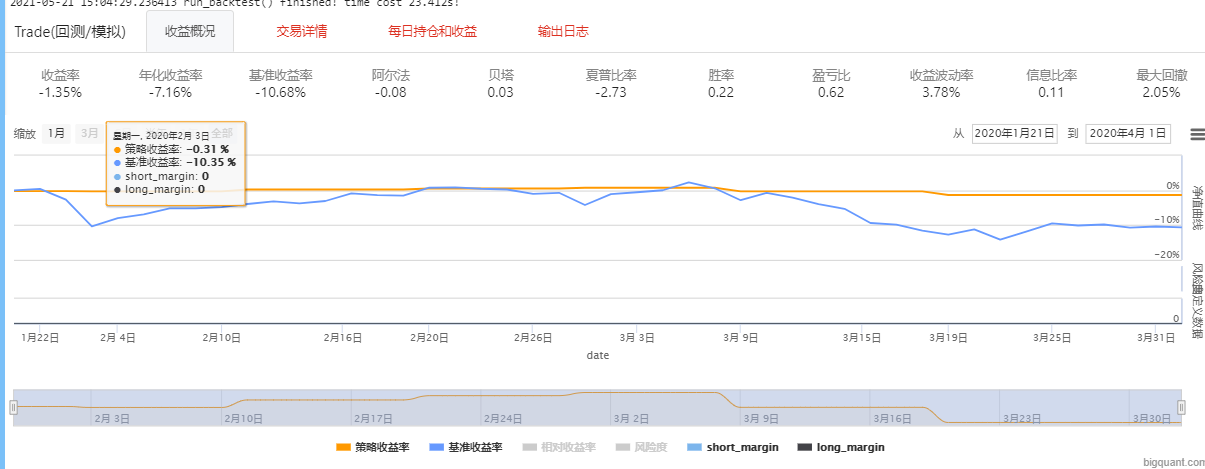